In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
import yfinance as yf
import datetime as dt

In [52]:
# Define ticker symbol and start/end dates
ticker = 'TSLA'
start = dt.datetime(2020, 1, 1)
end = dt.datetime.now()

# Download historical data
stock_data = yf.download(ticker, start=start, end=end)

stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500
2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500
2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000
2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500
2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500


In [53]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1171 entries, 2020-01-02 to 2024-08-27
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1171 non-null   float64
 1   High       1171 non-null   float64
 2   Low        1171 non-null   float64
 3   Close      1171 non-null   float64
 4   Adj Close  1171 non-null   float64
 5   Volume     1171 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 64.0 KB


In [54]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1.171000e+03
mean,207.214809,211.871437,202.242240,207.153151,207.153151,1.282673e+08
std,80.477303,82.087297,78.574012,80.292264,80.292264,8.389334e+07
min,24.980000,26.990667,23.367332,24.081333,24.081333,2.940180e+07
25%,169.209999,174.364998,166.619995,170.119995,170.119995,7.700545e+07
50%,216.800003,221.683334,211.009995,216.520004,216.520004,1.038899e+08
75%,255.785004,260.625000,250.533333,256.509995,256.509995,1.484560e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


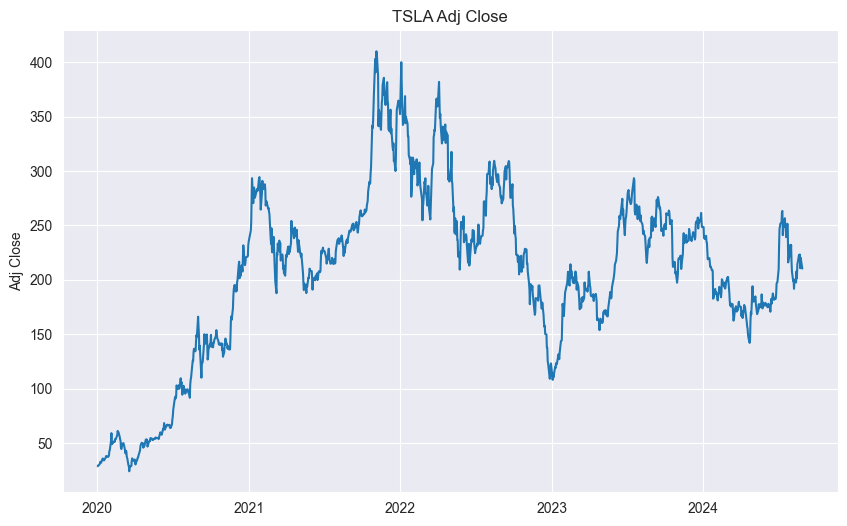

In [89]:
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Adj Close'])
plt.title(f"{ticker} Adj Close")
plt.ylabel("Adj Close")
plt.show()

In [56]:
null = stock_data.isnull().sum()
print(null)

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [57]:
duplicates = stock_data.duplicated().sum()
print(duplicates)

0


In [58]:
stock_data.to_csv('stock_data.csv')

In [59]:
# Daily returns
stock_data['Daily Return'] = stock_data['Adj Close'].pct_change()

In [79]:
# Cumulative returns
stock_data['Cumulative Return'] = (1 + stock_data['Daily Return']).cumprod()

In [80]:
# Moving averages
stock_data['50-Day MA'] = stock_data['Adj Close'].rolling(window=50).mean()
stock_data['200-Day MA'] = stock_data['Adj Close'].rolling(window=200).mean()

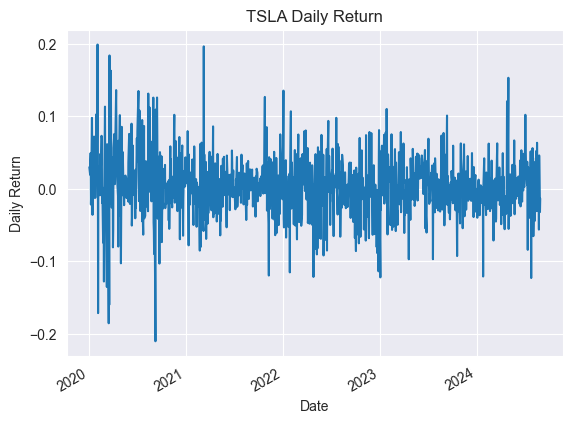

In [81]:
# Plot daily returns
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Daily Return'])
plt.title(f"{ticker} Daily Returns")
plt.ylabel("Daily Return")
plt.show()

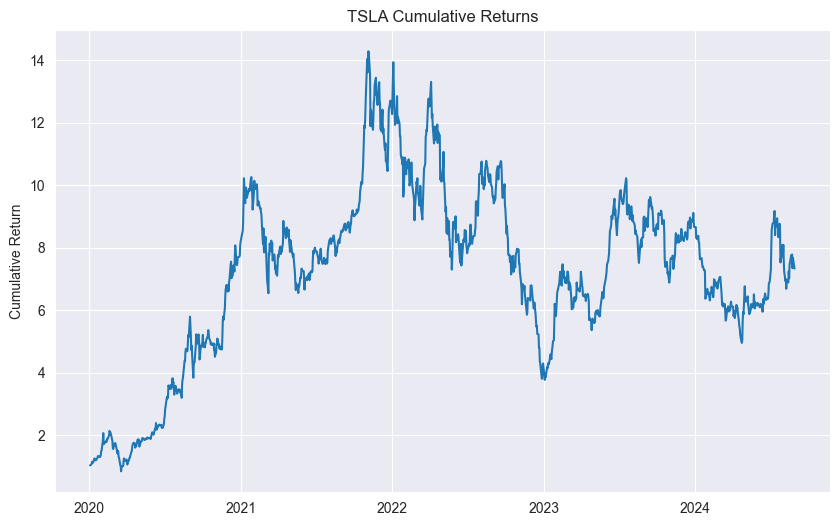

In [90]:
# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Cumulative Return'])
plt.title(f"{ticker} Cumulative Returns")
plt.ylabel("Cumulative Return")
plt.show()

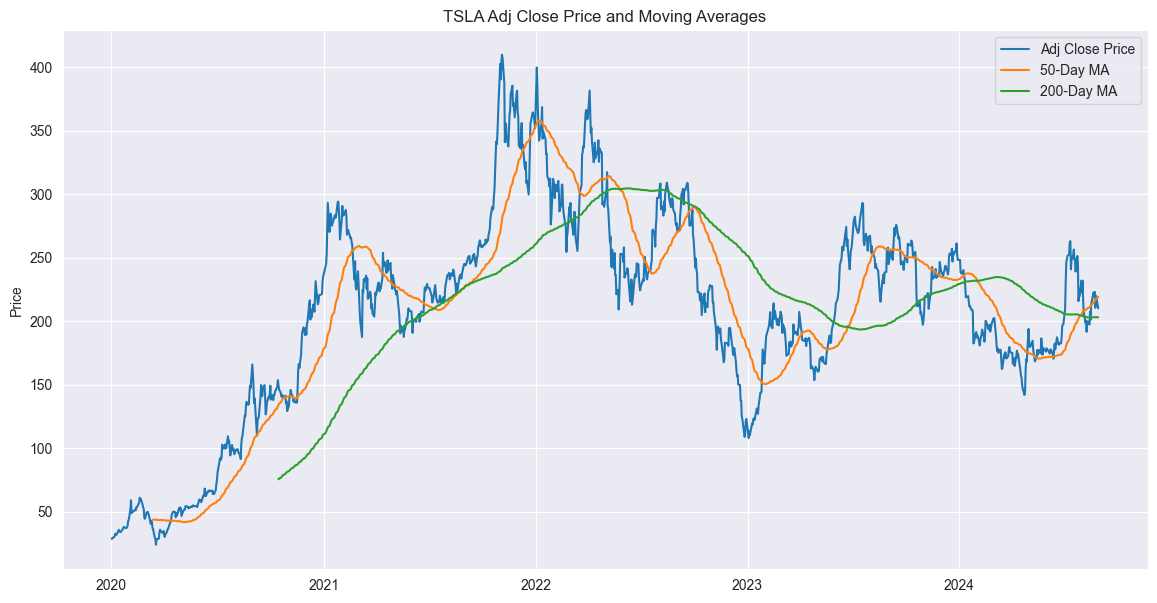

In [91]:
# Plot moving averages
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Adj Close'], label = "Adj Close Price")
plt.plot(stock_data['50-Day MA'], label="50-Day MA")
plt.plot(stock_data['200-Day MA'], label="200-Day MA")
plt.title(f"{ticker} Adj Close Price and Moving Averages")
plt.ylabel("Price")
plt.legend()
plt.show()

In [102]:
# Identifying golden crosses
golden_cross = stock_data[(stock_data['50-Day MA'] > stock_data['200-Day MA']) & (stock_data['50-Day MA'].shift(1) <=stock_data['200-Day MA'].shift(1))]

# Identifying death crosses
death_cross = stock_data[(stock_data['50-Day MA'] < stock_data['200-Day MA']) & (stock_data['50-Day MA'].shift(1) >=stock_data['200-Day MA'].shift(1))]

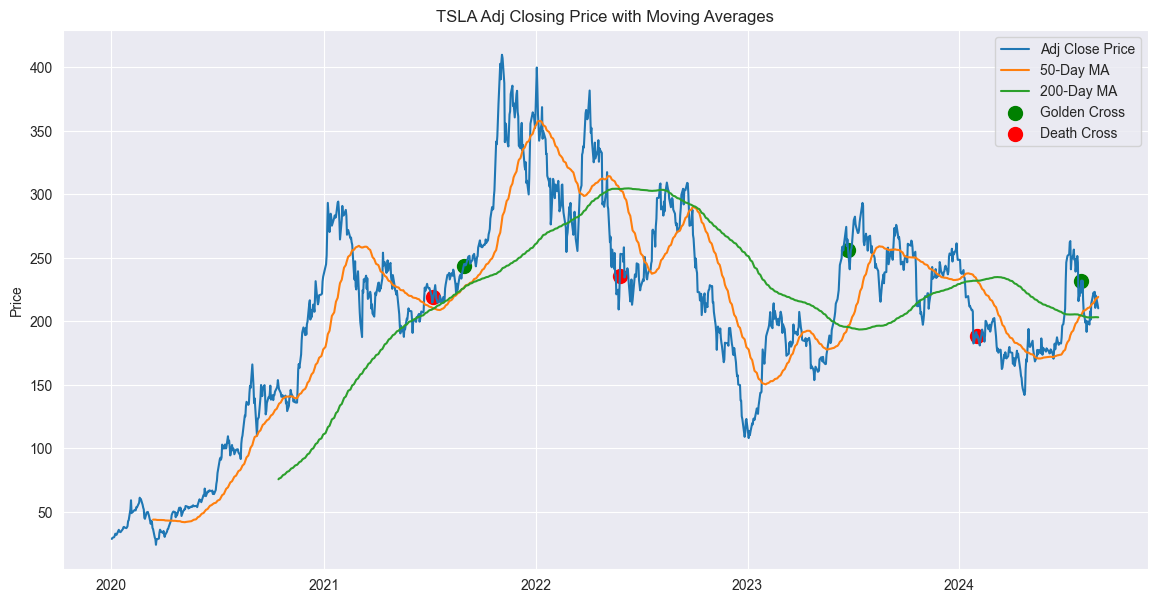

In [105]:
# Plot with markers
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Adj Close'], label = "Adj Close Price")
plt.plot(stock_data['50-Day MA'], label="50-Day MA")
plt.plot(stock_data['200-Day MA'], label="200-Day MA")

# Plot golden crosses
plt.scatter(golden_cross.index, stock_data.loc[golden_cross.index, 'Adj Close'], marker='o', color='green', s=100, label='Golden Cross')

# Plot death crosses
plt.scatter(death_cross.index, stock_data.loc[death_cross.index, 'Adj Close'], marker='o', color='red', s=100, label='Death Cross')

plt.title(f"{ticker} Adj Closing Price with Moving Averages")
plt.ylabel("Price")
plt.legend()
plt.show()